In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm

import warnings
warnings.simplefilter(action='ignore')

# California Housing Prices
This dataset contains median house prices for California districts derived from the 1990 census.
> https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
print(df.columns)
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
             'households', 'median_income', 'median_house_value']
categorical = ['ocean_proximity']

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [4]:
df[numerical].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
print(f"Number of rows [{len(df)}]")
print("\nNumber null values in rows:")
print(df.isnull().sum())

Number of rows [20640]

Number null values in rows:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


### Comment
After reviewing the data, we see that we have 207 values in one column that are nulls. Since this is only 1% of the data, we can delete these rows or try to replace them with some known values.

In [6]:
df.total_bedrooms.describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

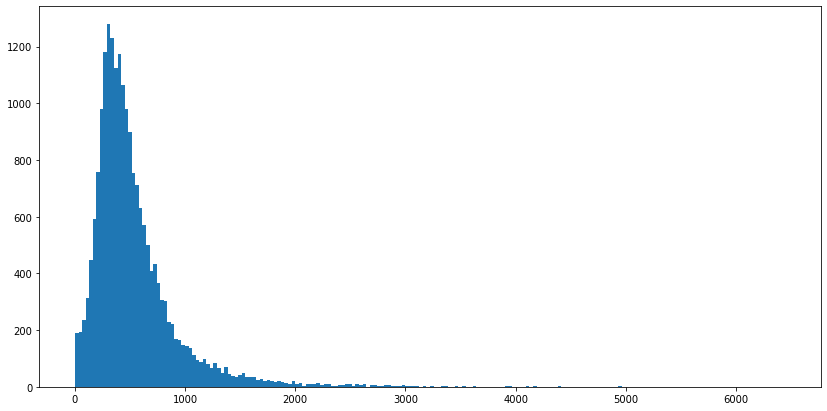

In [7]:
plt.figure(figsize=(14, 7))
plt.hist(df.total_bedrooms, bins=200);

### Comment
I got information about the data stored in the column as well as the distribution of the data. The data is skewed to the right, so replacing it with an average value may not be a good solution. For such data, if we want to choose the optimal data for replacement, it will be better to use the median.

In [8]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df.total_bedrooms.median())

In [9]:
print("\nNumber null values in rows:")
print(df.isnull().sum())


Number null values in rows:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


### Comment
The data has been prepared and cleaned. In the next steps, I will try to find the dependencies between them.

<AxesSubplot:>

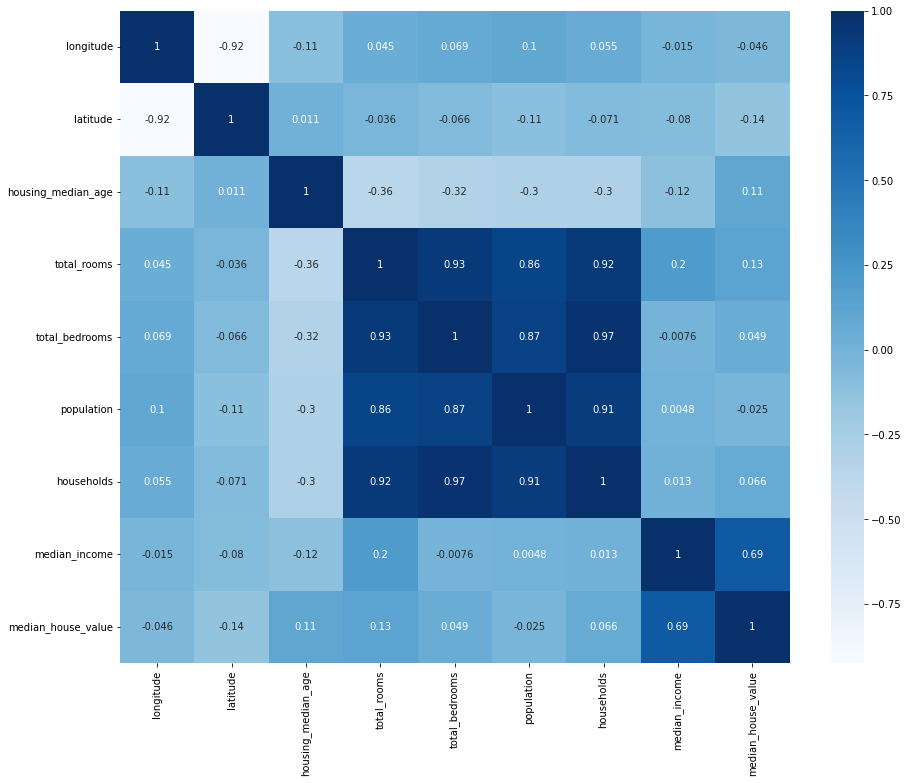

In [10]:
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, cbar=True, annot=True, annot_kws={'size':10}, cmap='Blues')

### Comment
Observing the correlations, we see that the greatest dependencies occur between the total number of rooms, bedrooms, population and households.

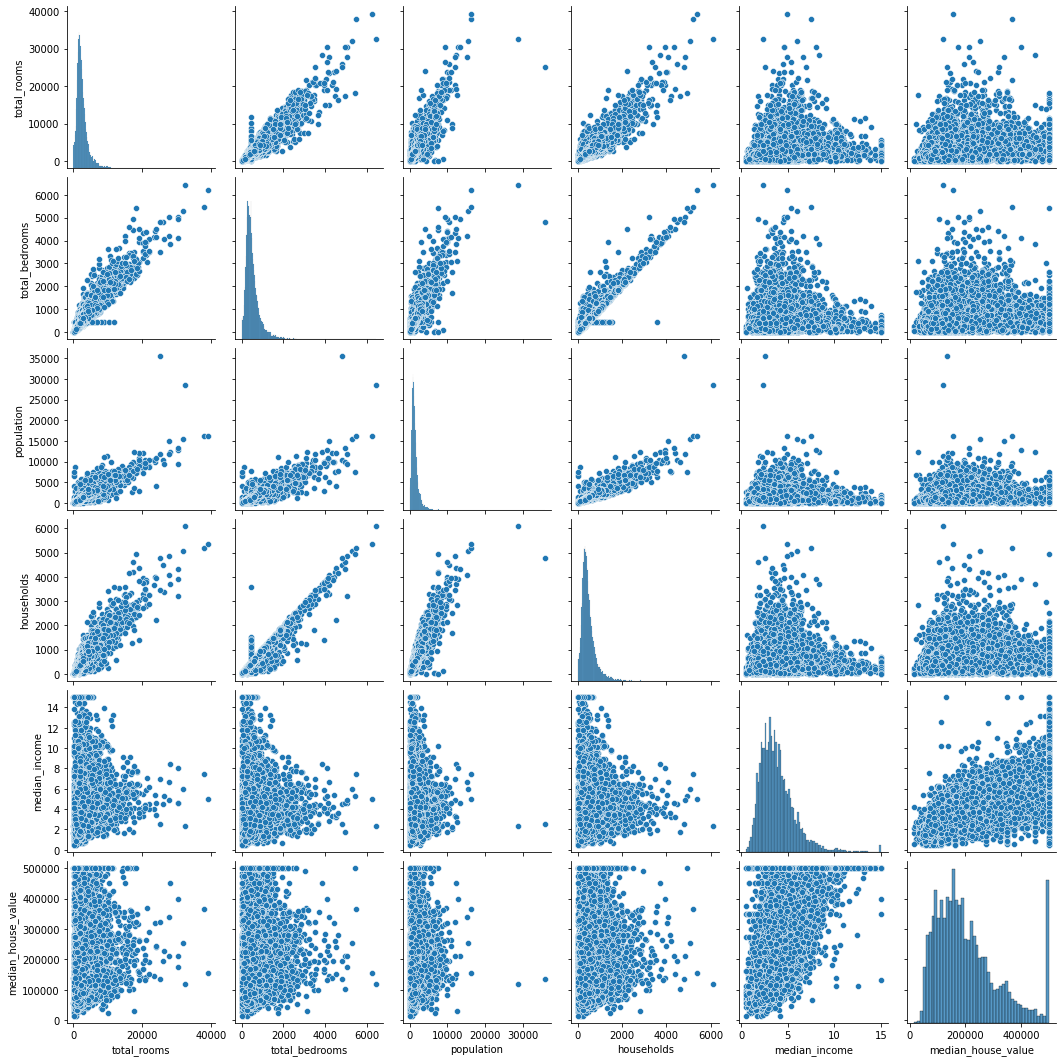

In [11]:
sns.pairplot(df, vars=['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'])
plt.show()

### Comment
We observe here many dependencies that could be used to build a model and predict data.

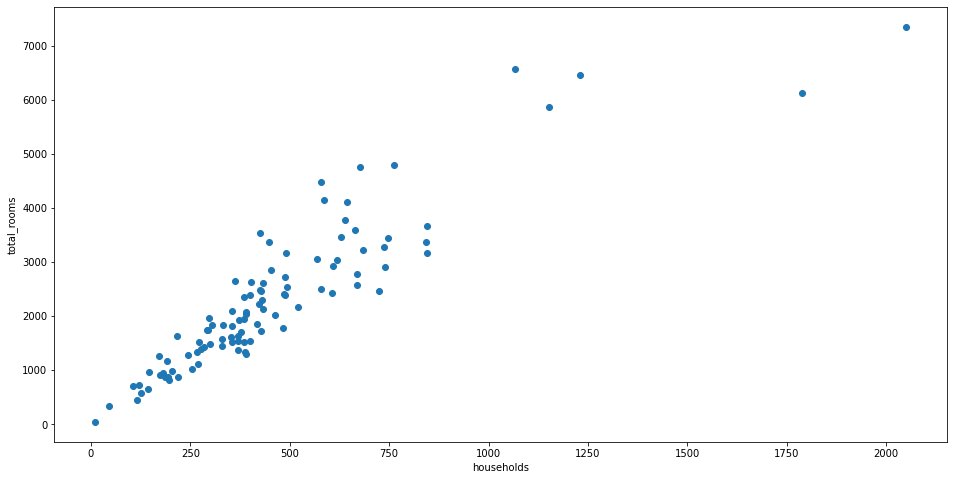

In [12]:
sample = df.sample(400, random_state=324)
X = sample.households.values.reshape(-1, 1)[:100]
y = sample.total_rooms.values.reshape(-1)[:100]

plt.figure(figsize=(16, 8))
plt.xlabel('households')
plt.ylabel('total_rooms')
plt.scatter(X, y)

### Comment
The correlation look interesting. The data is crowded as with the data we used in the basic sets, this may cause some errors in further analysis, which I mentioned in the previous set.

## Helper functions

In [13]:
def linear_model(X, y, model):
    print(f"Regression coefficient y versus x (slope) [{model.coef_}]")
    print(f"Independent term in the linear model [{model.intercept_}]")

    prediction = model.predict(X)
    error = mean_squared_error(y, prediction)
    print(f"Mean squared error equals: [{error}]")

    plt.figure(figsize=(14, 8))
    plt.xlabel('households')
    plt.ylabel('total_rooms')
    plt.title('Simple linear regression')
    plt.scatter(X, y)
    plt.plot(X, prediction, c='r')

### Comment
Above function is predicting and ploting simple regression of given model.

In [14]:
def polynomial_draw(X, y, model):
    fig, axes = plt.subplots(5, 2, figsize=(16, 26))
    x_axes = 0
    X_new = np.arange(X.min(), X.max(), 1).reshape(-1,1)
    errors = []

    for order in range(1, 11):
        poly = PolynomialFeatures(order, include_bias = False)
        X_order = poly.fit_transform(X)
        model.fit(X_order, y)
        prediction = model.predict(poly.fit_transform(X_new))
        y_axes = (order + 1) % 2

        axes[x_axes][y_axes].ticklabel_format(axis="y", style='plain')
        axes[x_axes][y_axes].set_xlabel('households')
        axes[x_axes][y_axes].set_ylabel('total_rooms')
        axes[x_axes][y_axes].set_title(f'Degree {order}')
        axes[x_axes][y_axes].scatter(X, y, c='b')
        axes[x_axes][y_axes].plot(X_new, prediction, c='r')

        x_axes = x_axes + 1 if (order + 1) % 2 else x_axes
        error = mean_squared_error(y, model.predict(X_order))
        errors.append(error)
        
    return errors

### Comment
Above function is predicting and ploting next polynomial degrees of given model. Additionaly it returns MSE for every training error used later in performance function.

In [15]:
def polynomial_performance(errors, degree):
    plt.figure(figsize=(11, 4))
    plt.ticklabel_format(axis="y", style='plain')
    plt.xlabel('degree')
    plt.ylabel('error')
    plt.title('Models performace')
    plt.plot([x for x in range(1, degree + 1)], errors[:degree],)

### Comment
Above function is ploting the performance of the given model across given number of degrees.

In [16]:
def polynomial_errors(X, y, model, degree):
    test_errors = []
    train_errors = []

    for order in range(1, degree + 1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

        poly = PolynomialFeatures(order, include_bias = False)
        X_order_train = poly.fit_transform(X_train)
        X_order_test = poly.fit_transform(X_test)
        model.fit(X_order_train, y_train)
        error = mean_squared_error(y_train, model.predict(X_order_train))
        train_errors.append(error)
        error = mean_squared_error(y_test, model.predict(X_order_test))
        test_errors.append(error)

    plt.figure(figsize=(11, 4))
    plt.xlabel('degree')
    plt.ylabel('error')
    plt.title('Models performace')
    plt.plot([x for x in range(1, degree + 1)], test_errors, label='test error')
    plt.plot([x for x in range(1, degree + 1)], train_errors, label='train error')
    plt.legend()
    
    return train_errors, test_errors

### Comment
Above function is spliting input data to training set and testing set. After this to all given degrees predict polynomial for given model and at the end plot train and test errors.

## Ordinary Least Squares
LinearRegression fits a model with coefficients $b = (b_1, ..., b_n)$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. 

$$f_{y}(b) = \dfrac{|Xb - y|^2}{n}, $$

$||$ - euclidean norm

Regression coefficient y versus x (slope) [[4.07973799]]
Independent term in the linear model [429.5436374997146]
Mean squared error equals: [343133.73327947303]


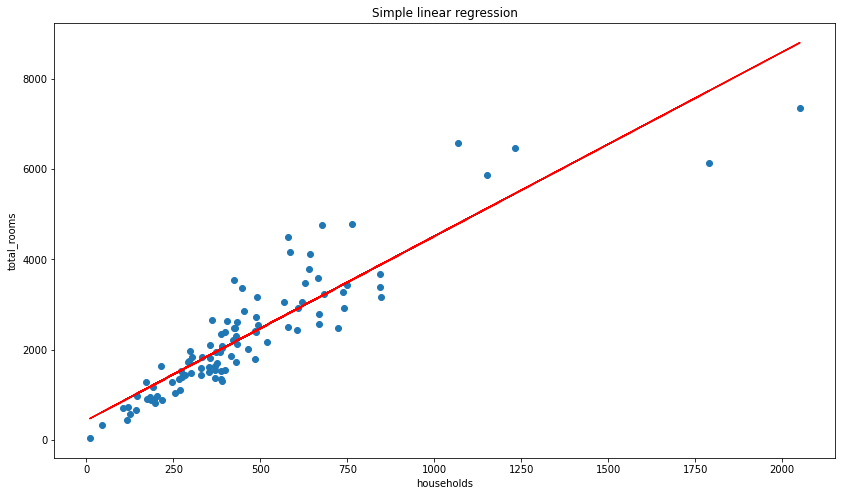

In [17]:
model = LinearRegression() 
model.fit(X, y)

linear_model(X, y, model)

### Comment
For this given part of date we can notice that LinearRegression fit well on the first part of data but the right outliers make the result worse and we see that simple line can't fit to that values.

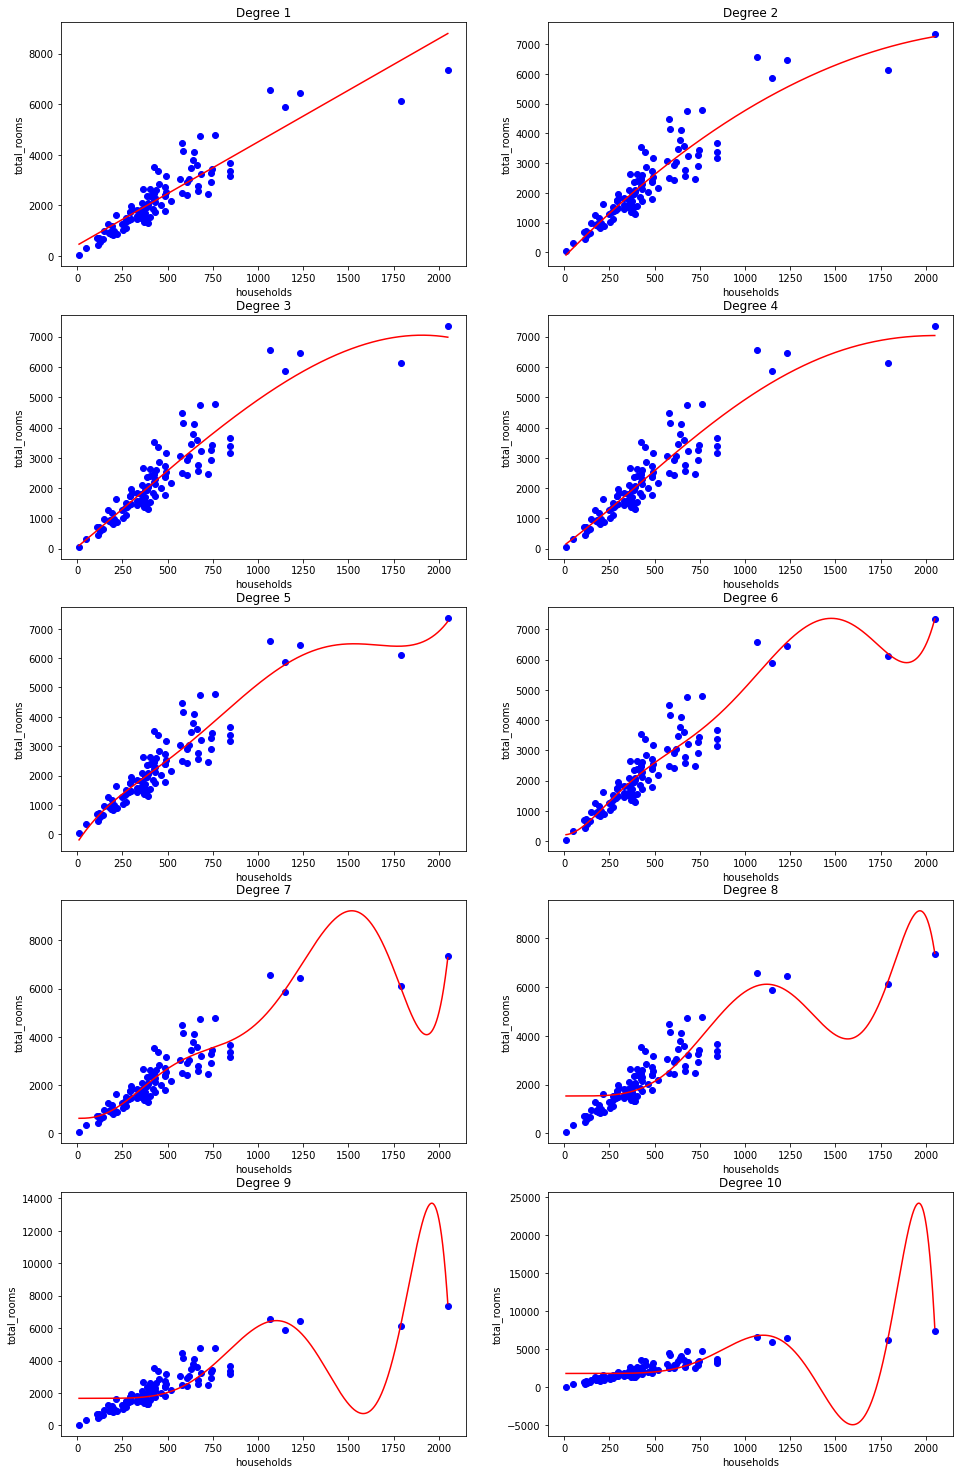

In [18]:
 errors = polynomial_draw(X, y, model)

### Comment
Applying polynomials to our LinearRegression is giving better results. We observe that as the degree of the polynomial increases, the curve fits better and better to our data.

But only to certain degree. For larger degrees, we can notice two things. The first is the problems with crowded data and the problem that our model can't handle it, so we can see that the prediction is not even close to the real values even though for the smaller polynomials we had a very good fit there. And the second problem is overfitting. Visually, we can see that for higher polynomials this phenomenon will spoil the results (especially for households in the 800-2000 range). The problem is so serious at 10 degree polynomials that we can even get a negative value as a result of the prediction.

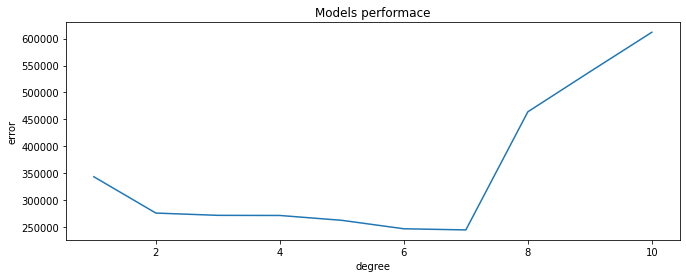

In [19]:
polynomial_performance(errors, 10)

<!-- ### Comment -->

### Comment
Now we can observe the error between the values predicted by the model and the real values (on which the model was trained). Second degree polynomial already gives us smaller error and with the next degrees this error is decreasing. But in the other hand with this problems of this model with dealing with high degree polinomials on crowded data (many different y to one x), the model performance if getting worse and worse (mathematically it should decrease).

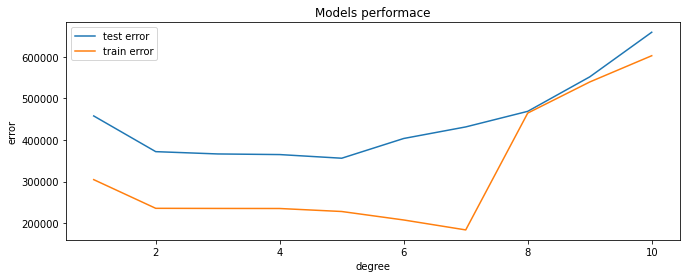

In [20]:
train_errors_lin, test_errors_lin = polynomial_errors(X, y, model, 10)

### Comment
As expected, the error of the data we trained on is smaller than the error of the test data. But we must remember that it all depends on the division into test and training data.

With the increase of the polynomial, maybe the error in the training data decreases, but for test data this error only to some degree decreases, then it increases. And the same as above, high degree are destroyed by LinearRegression model (and also test error by the overfitting).

Optimal solution for this model probably will be polynomial with degree 2. The errors are little bigger than for degree 5 but this solution is faster and require less computational power.

## Ridge
Ridge regression resolving some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients in scenarios where the independent variables are highly correlated

$$f_{y}(b) = \dfrac{|Xb - y|^2}{n} + \alpha\dfrac{|b|^2}{n}$$

$||$ - euclidean norm

The $\alpha$ parameter controls the amount of shrinking: the larger the value of, the greater the amount of shrinking and thus the coefficients become more resistant to collinearity.

**And now more simply**<br>
This model works by attempting at increasing the bias to improve the fitting on training data. Simply this works by changing the slope of the LinearRegression model line. When $\alpha$ increases our slope is reduced and line become more horizontal.

Regression coefficient y versus x (slope) [[1.30299084]]
Independent term in the linear model [1714.4000774087037]
Mean squared error equals: [1066748.95414258]


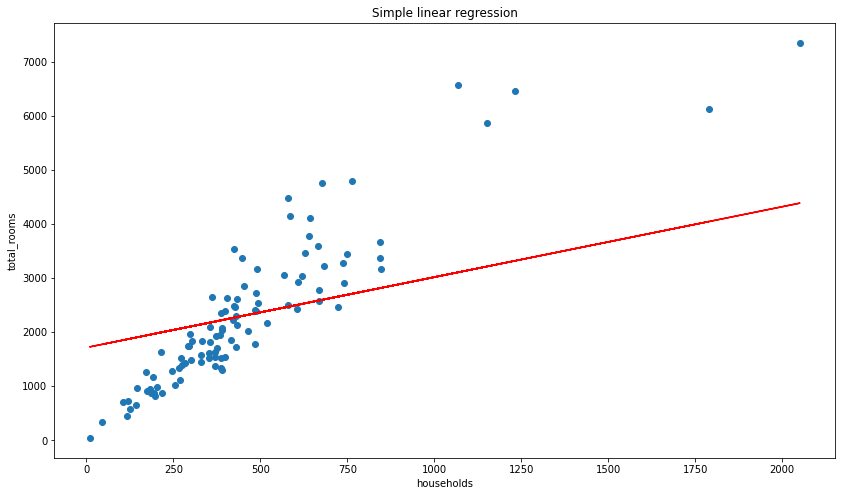

In [21]:
model = Ridge(alpha=2e7)
model.fit(X, y)

linear_model(X, y, model)

### Comment
Above I presented the example how this Ridge model changing the slope (we should't give that big value normally)

Regression coefficient y versus x (slope) [[4.0797376]]
Independent term in the linear model [429.54381853281416]
Mean squared error equals: [343133.73327948747]


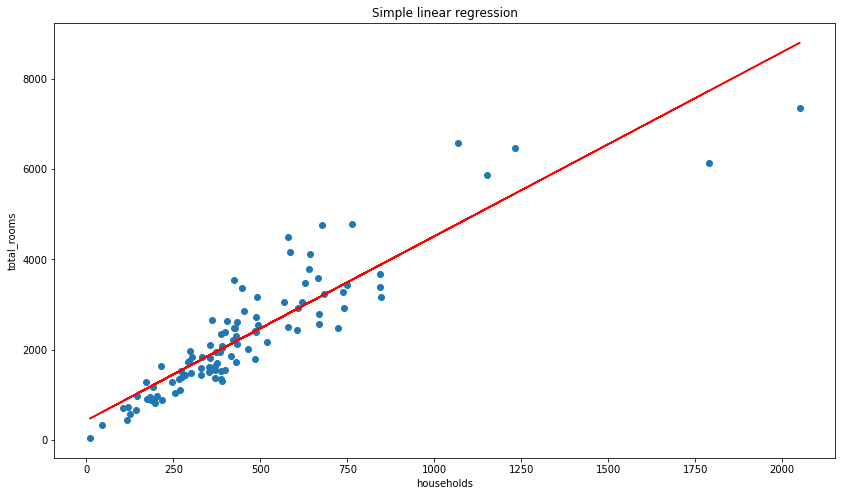

In [22]:
model = Ridge(alpha=0.9) 
model.fit(X, y)

linear_model(X, y, model)

### Comment
The use of the Ridge model did not change the result in our case. For our purpose and date the better will be increasing the slope not decreasing. But this model it's not totally useless for us.

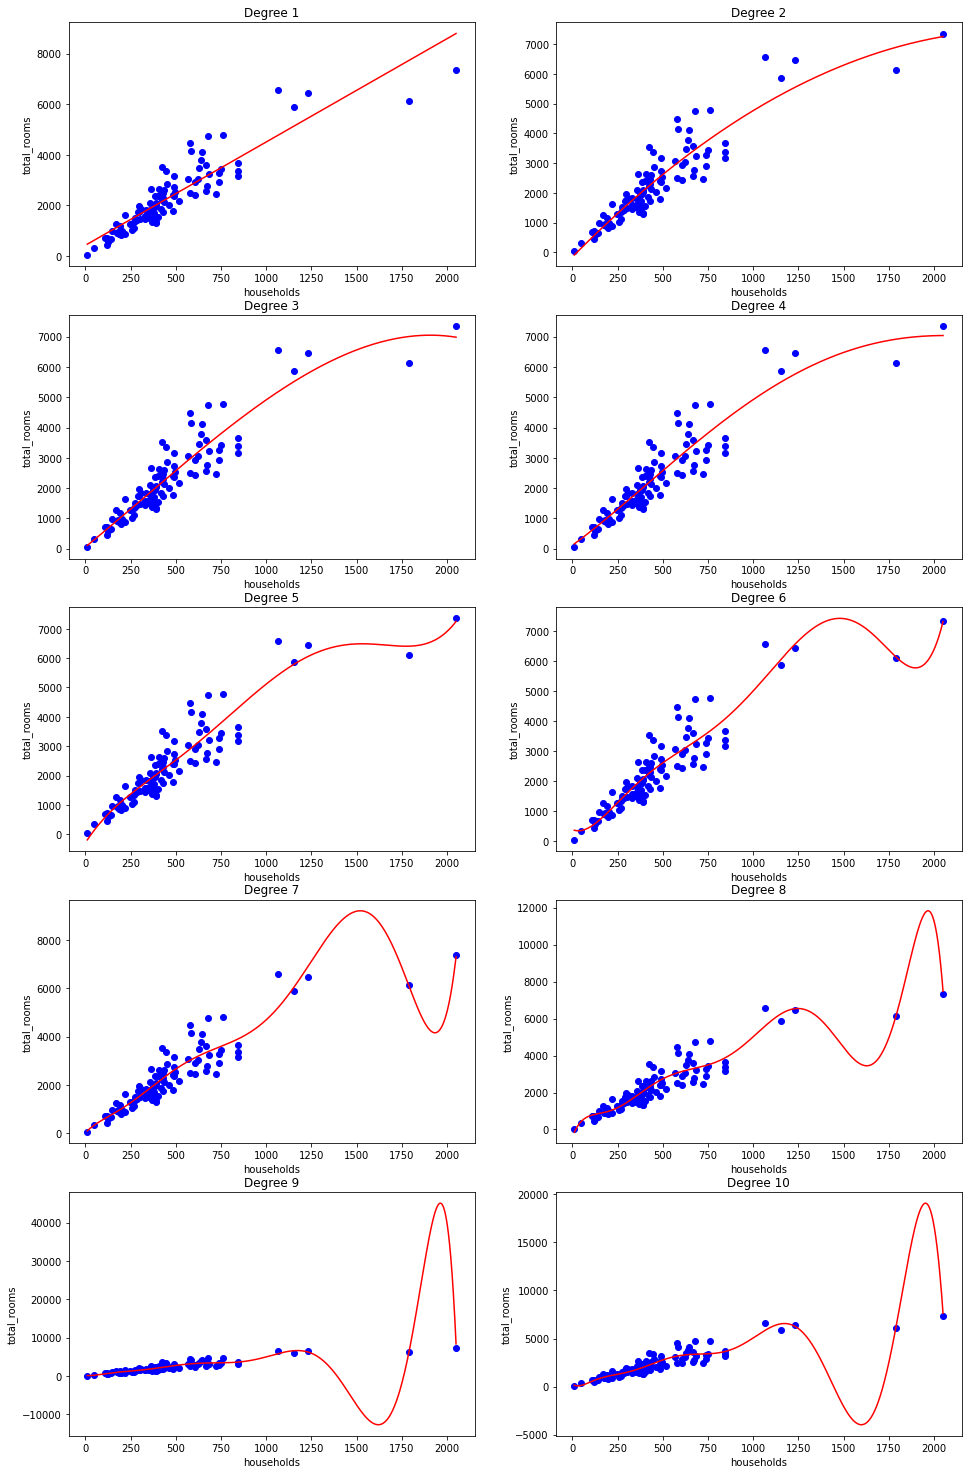

In [23]:
errors = polynomial_draw(X, y, model)

### Comment
The use of the ridge regression model did not significantly improve the fitting error, but it did help with the problem of data crowding. We no longer see anomalies there and our prediction curve fits more and more points (increasing overfitting at the same time). But in the other hand for hihger degrees there where data are not crowded it decreased overfitting more than in LinearRegression.

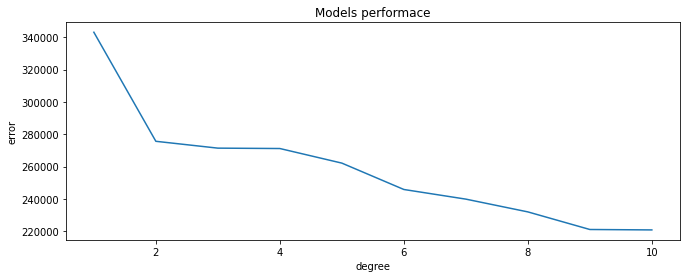

In [24]:
polynomial_performance(errors, 10)

### Comment
As I mentioned a moment ago, ridge regression fixes the problem with crowded data. The training error doesn't start to increase at some point like on LinearRegression. This is due to the fact that this model deals better with solving the singular matrix (det=0).

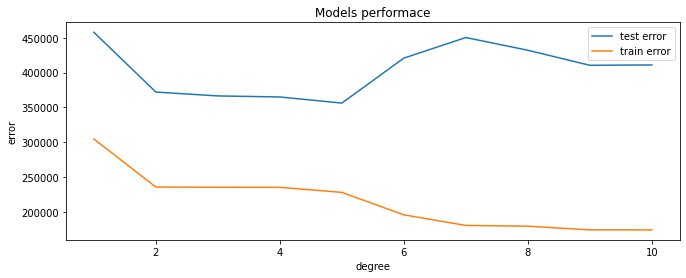

In [25]:
train_errors_rid, test_errors_rid = polynomial_errors(X, y, model, 10)

### Comment
Since for our data, the performance of ridge regression only improves the fit of crowded data, apart from a smaller fitting error for polynomials, nothing changes compared to linear regression. We also see that our data is not good (and their division) because with a model in which we had larger overfitting in empty spaces, we get smaller prediction errors of test data.

## Lasso
Lasso regression is very similar to Ridge regression, but instead of introducing a bias term  using squared slope it is adding the absolute value of the slope. 

$$f_{y}(b) = \dfrac{|Xb - y|_2^2}{n} + \alpha\dfrac{|b|_1}{n}$$

$||_2$ - euclidean norm
$||_1$ - taxi norm

Lasso regression is useful for us becouse it help to reduce the overfitting by reducing the slope to be exacly 0. And that eliminate some of the useless independant variables.

Regression coefficient y versus x (slope) [[4.07952488]]
Independent term in the linear model [429.64224574760897]
Mean squared error equals: [343133.7375415861]


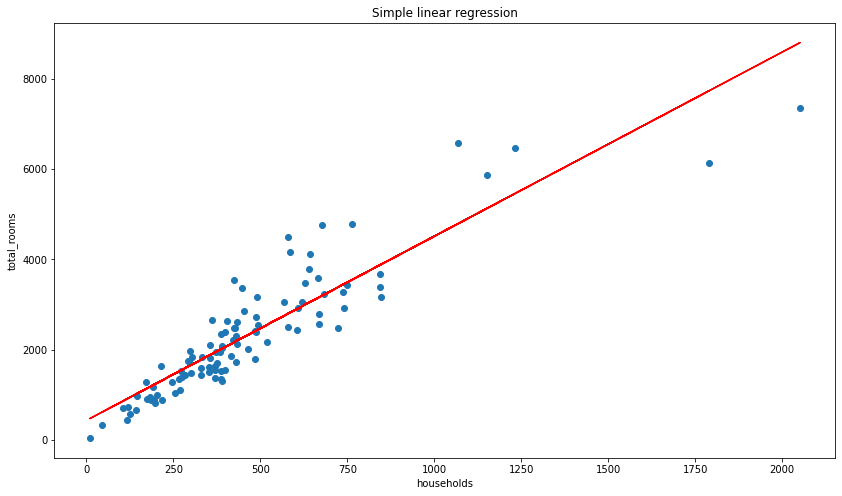

In [26]:
model = Lasso(alpha=20) 
model.fit(X, y)

linear_model(X, y, model)

### Comment
Result the same as in the Ridge regression. We should not increase the alpha with our data.

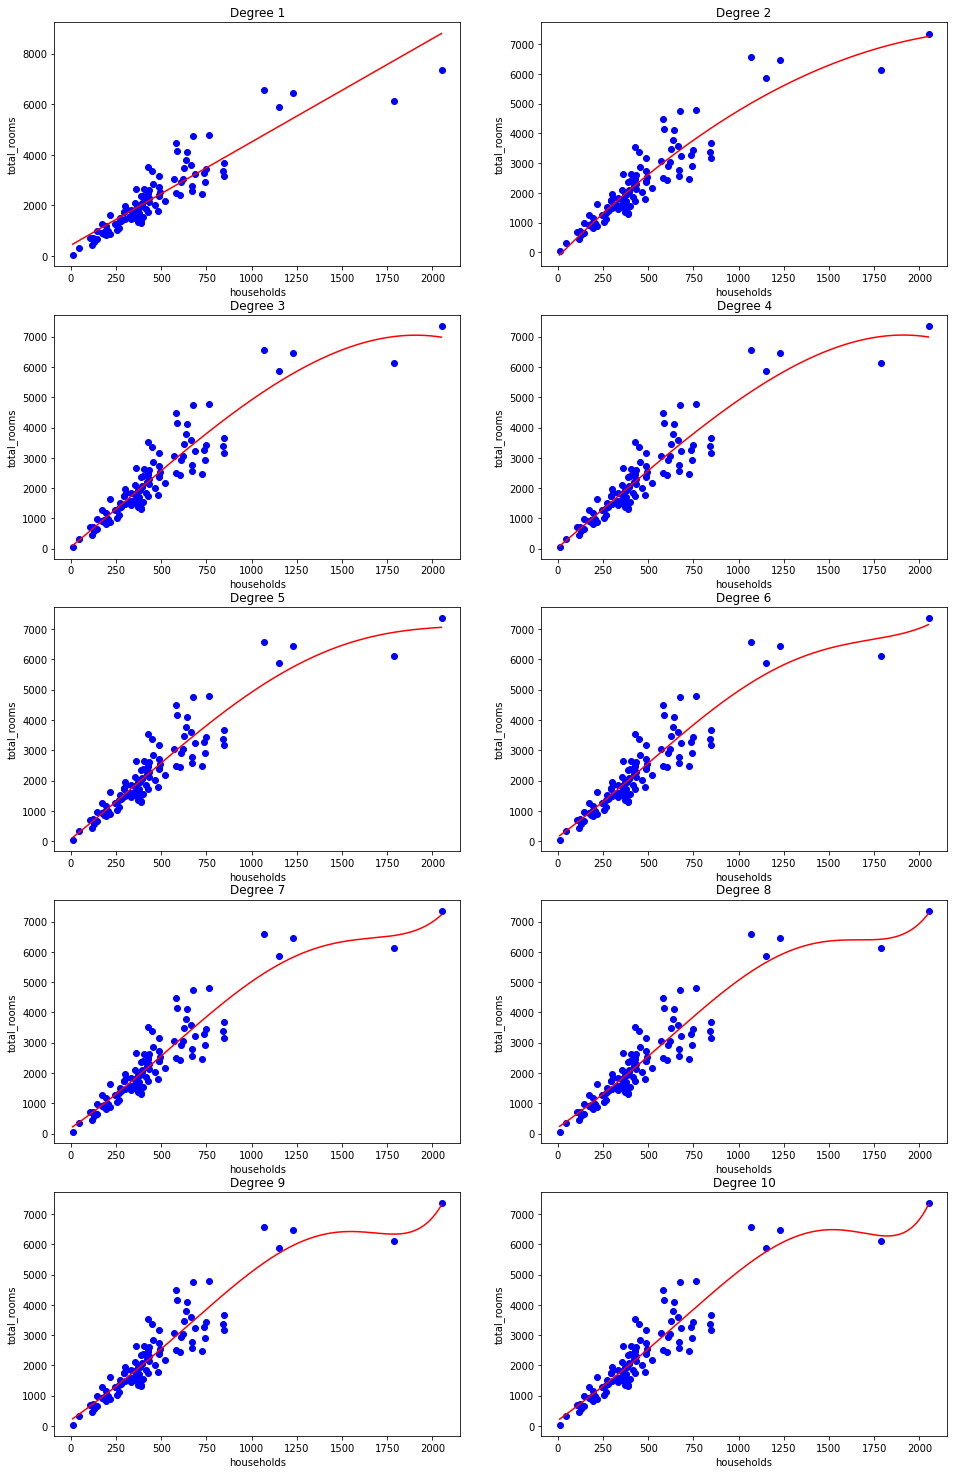

In [27]:
errors = polynomial_draw(X, y, model)

### Comment
Lasso regression helped both with the error related to data grouping and also practically eliminated overfitting. Using this model, we can certainly expect a better prediction of unknown values.

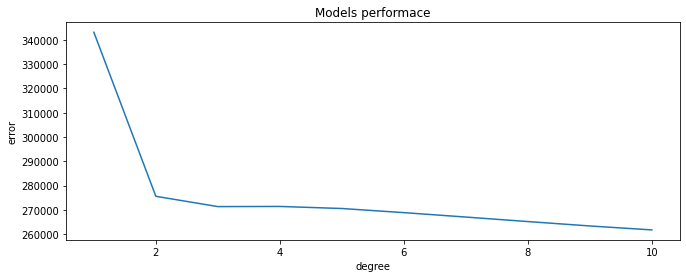

In [28]:
polynomial_performance(errors, 10)

### Comment
As some variables may have been discarded and not taken into account, the performance of the model is worse than in the case of ridge regression.

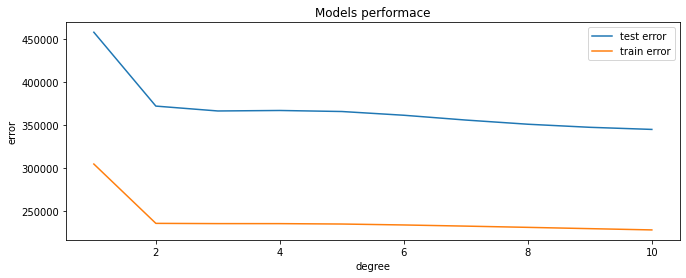

In [29]:
train_errors_las, test_errors_las = polynomial_errors(X, y, model, 10)

### Comment
We can observe here that for our data, as the degree of the polynomial increases and the training error decreases, the testing error is lower and lower.

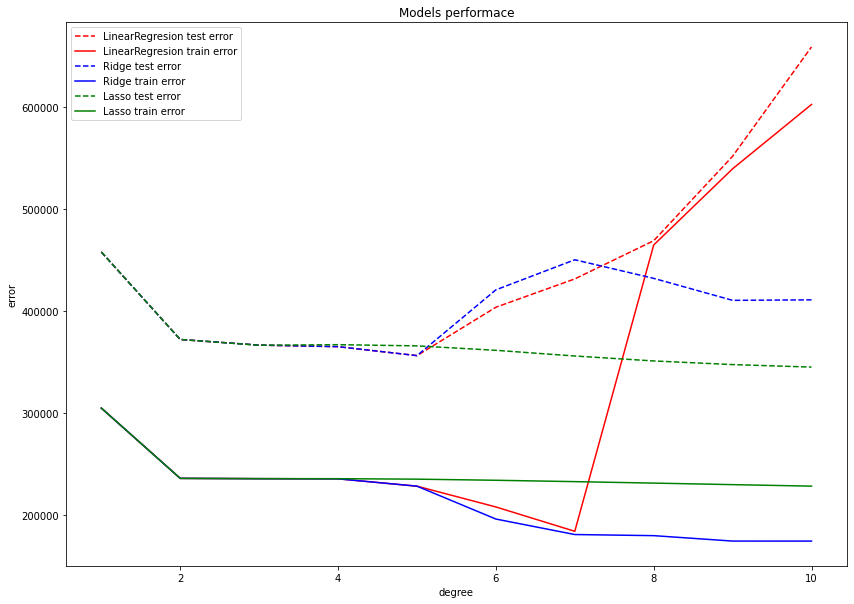

In [30]:
plt.figure(figsize=(14, 10))
plt.xlabel('degree')
plt.ylabel('error')
plt.title('Models performace')
plt.plot([x for x in range(1, len(test_errors_lin) + 1)], test_errors_lin, label='LinearRegresion test error', c='r', linestyle='dashed')
plt.plot([x for x in range(1, len(train_errors_lin) + 1)], train_errors_lin, label='LinearRegresion train error', c='r')
plt.plot([x for x in range(1, len(test_errors_rid) + 1)], test_errors_rid, label='Ridge test error', c='b', linestyle='dashed')
plt.plot([x for x in range(1, len(train_errors_rid) + 1)], train_errors_rid, label='Ridge train error', c='b')
plt.plot([x for x in range(1, len(test_errors_las) + 1)], test_errors_las, label='Lasso test error', c='g', linestyle='dashed')
plt.plot([x for x in range(1, len(train_errors_las) + 1)], train_errors_las, label='Lasso train error', c='g')
plt.legend()

### Comment
Comparing the different linear regression models, we see that for each model the training errors and testing errors are similar (up to degree 5). In higher degrees, we can easily see that LinearRegression gives us the worst results (it is related to the singular matrix). The Ridge regression gives us smaller training error than the Lasso regression, but bigger testing error.

## Multi-features predictions

In [31]:
y = df.population.values.reshape(-1)
order_errors = []

for order in range(1, 7):
    variables = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                 'households', 'median_income', 'median_house_value']
    X = np.zeros(len(y)).reshape(-1, 1)
    best_vars = set()
    
    poly = PolynomialFeatures(order, include_bias = False)
    X = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X, y)

    prediction = model.predict(X)
    error = mean_squared_error(y, prediction)
    print(f"Initial error equals: [{error}]")
    print(f"Polynomial order: [{order}]\n")

    for i in range(1, len(variables) + 1):
        errors = {}

        for var in variables:   
            curr_vars = best_vars.copy()
            curr_vars.add(var)
            
            X = poly.fit_transform(df[list(curr_vars)].values.reshape(-1, i))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_train)
            curr_error = mean_squared_error(y_pred, y_train)

            if curr_error < error:
                errors[var] = curr_error

        if len(errors) > 0:
            errors = dict(sorted(errors.items(), key=lambda item: item[1]))
            best_var = next(iter(errors))
            best_vars.add(best_var)
            variables.remove(best_var)
            error = errors[best_var]
            print(f"Current best error equals: [{error}], adding [{best_var}]")
        else:
            break
        
    order_errors.append((order, error, best_vars))
    print()
    

order_errors = list(sorted(order_errors, key=lambda item: item[1]))
print(f"Best polynomial degree: [{order_errors[0][0]}]")
print(f"Best error: [{order_errors[0][1]}]")
print(f"Best features list: {order_errors[0][2]}")

Initial error equals: [1282408.3220366866]
Polynomial order: [1]

Current best error equals: [186175.15619888273], adding [households]
Current best error equals: [177847.4432870505], adding [median_house_value]
Current best error equals: [170396.03242363757], adding [total_rooms]
Current best error equals: [161069.77520795914], adding [total_bedrooms]
Current best error equals: [154937.95200016967], adding [latitude]
Current best error equals: [153319.6044055209], adding [longitude]
Current best error equals: [153203.16861796408], adding [median_income]
Current best error equals: [153202.4832631116], adding [housing_median_age]

Initial error equals: [1282408.3220366866]
Polynomial order: [2]

Current best error equals: [186150.88535185365], adding [households]
Current best error equals: [171628.84512029472], adding [total_rooms]
Current best error equals: [150777.03110063632], adding [median_house_value]
Current best error equals: [143268.90392004486], adding [latitude]
Current best e

### Comment
On this step I prepared the list feature that I want the greedy algorithm to searched for best features that gives minimal error when predicting population. Also I prepared initial variables and counted first error (when values equal to 0).

Then for all the polynomial orders I implemented greedy algorithm for features selecting. Firstly I started with zero features and counted best prediction for all values. Then I repeated this with best feature and adding next features. That I can find all best features and the error will never increase. I finished when all variables was taken or when adding new variables didn't decreas error.

For predicting the population it turned on that the best performance we having using 6 degree polynomial. 

# Salary
This dataset is very simple. This data consists of salary and years of experience of 35 jobholders. 
> https://www.kaggle.com/datasets/rsadiq/salary?datasetId=80116

In this part I wanted to experiment a bit with implementing the Ridge regression. Yhat is the reason for choosing such a simple dataset that I will modify anyway.

In [32]:
df = pd.read_csv('Salary.csv')
df.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [33]:
X = df.YearsExperience.values.reshape(-1,1)
y = df.Salary.values.reshape(-1,1)
print(np.shape(X))
print(np.shape(y))

(35, 1)
(35, 1)


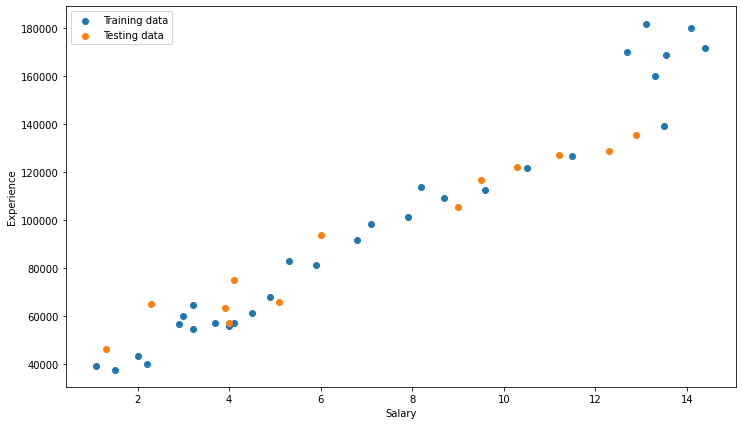

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

X_train = np.append(X_train, [14.1, 13.1, 12.7, 13.3, 14.4, 13.55]).reshape(-1,1)
y_train = np.append(y_train, [180000, 182000, 170000, 160000, 172000, 169000]).reshape(-1,1)

X_test = np.append(X_test, [2.3, 4.1]).reshape(-1,1)
y_test = np.append(y_test, [65000, 75000]).reshape(-1,1)

plt.figure(figsize=(12, 7))
plt.xlabel('Salary')
plt.ylabel('Experience')
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Testing data")
plt.legend()

### Comment
Above, I added some artificial points to our data to forcibly fit the training points while making the test data not well predicted.

## Linear Regression

In [35]:
def predict(b, X):
    return np.dot(X, b)

def cost(y_pred, y_true):
    norm = np.linalg.norm(y_pred - y_true)
    cost = (norm**2)/(len(y_pred))
    return np.round(cost, 2)

In [36]:
bias = np.ones(X_train.shape[0]).reshape(-1,1)
X_biased = np.append(X_train, bias, axis=1)

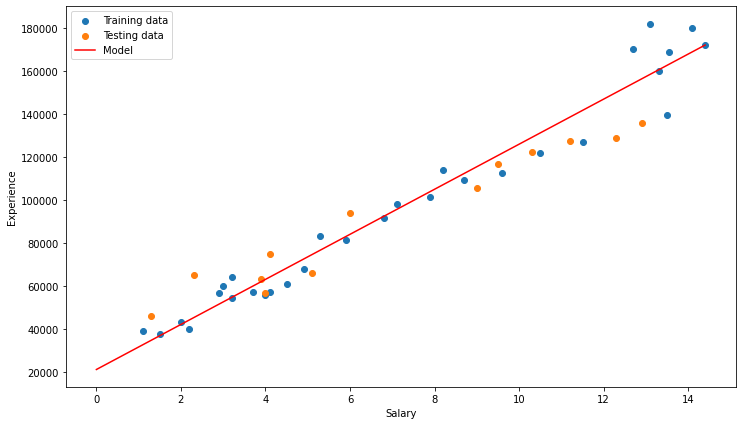

Training error = [80956834.36]
Testing error  = [154107606.91]


In [37]:
nb_of_bs = 201 # compute the cost nb_of_bs times in each dimension
b1 = np.linspace(-500, 20000, num=nb_of_bs) # slope coefficient
b2 = np.linspace(-3e4, 1.5e5, num=nb_of_bs) # bias
b_x, b_y = np.meshgrid(b1, b2) # generate grid
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) # initialize cost matrix

# Fill the cost matrix for each combination of coefficients
for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i,j] = cost(predict(np.array([[b_x[i,j]], [b_y[i,j]]]), X_biased) , y_train)
        
plt.figure(figsize=(12, 7))
plt.xlabel('Salary')
plt.ylabel('Experience')
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Testing data")

best_b1_2d_ind, best_b2_2d_ind = np.unravel_index(cost_arr_2d.argmin(), cost_arr_2d.shape)
best_b1 = b_x[best_b1_2d_ind,best_b2_2d_ind]
best_b2 = b_y[best_b1_2d_ind,best_b2_2d_ind]

x_model = np.linspace(0, np.max(X_train), 1000)
y_model = best_b1*x_model + best_b2
plt.plot(x_model, y_model, label='Model', c='r')
plt.legend()
plt.show()

test_pred = best_b1*X_test + best_b2

print(f"Training error = [{cost_arr_2d[best_b1_2d_ind,best_b2_2d_ind]}]")
print(f"Testing error  = [{cost(test_pred, y_test)}]")

### Comment
Our simple linear regression model only fits the training data. We see that in the case of the test data, this fit is 2 times worse.

## Ridge
**Closed-form**

The cost function in matrix notation for ridge regression we can show as below:

$$cost(b) = (y-Xb)^T(y-Xb) + \alpha b^Tb$$

Now we differentiate this function, set it equal to zero, and solve.

$$\bigtriangledown cost(b) = \bigtriangledown [(y-Xb)^T(y-Xb)] + \alpha \bigtriangledown [b^Tb] = -2X^T(y-Xb) + 2\alpha Ib$$
$$b = (X^TX+\alpha I)^{-1}X^Ty$$

In [38]:
def closed_form_ridge(X, y, alpha=0):
    bias = np.ones((len(X), 1))
    X_biased = np.column_stack((bias, X))
    I = np.identity(X_biased.shape[1])
    I[0][0] = 0
    return np.linalg.inv(X_biased.T @ X_biased + alpha * I) @ (X_biased.T) @ y

### Comment
Above function is the implementation of direct formula for ridge regression. We adding the bias to our data and we need to remember that we need set the first value in identity to 0 because there is our interception.

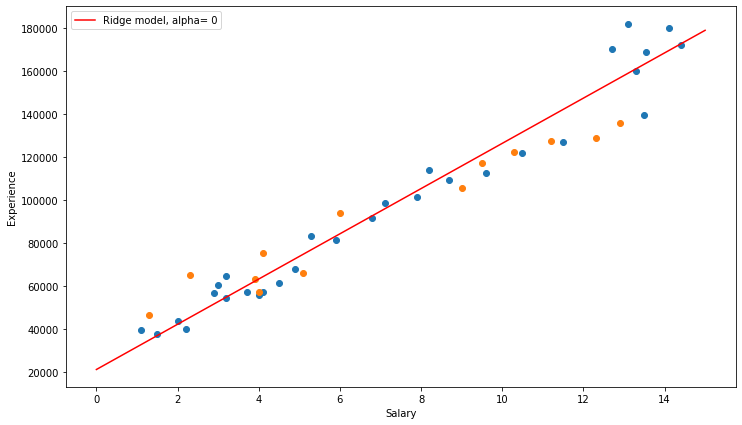

In [39]:
b = closed_form_ridge(X_train, y_train)

plt.figure(figsize=(12, 7))
plt.xlabel('Salary')
plt.ylabel('Experience')
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

x_new = np.arange(0, np.maximum(X_train.max(), X_test.max()) + 1, 1)
plt.plot(x_new, b[1] * x_new + b[0], label=f"Ridge model, alpha= 0", c='r')

plt.legend()

### Comment
When alpha is 0 the additional constraints disappear and we get a simple linear regression model. As we can see, the result is identical to the result above. 

[[32496.11170697]
 [ 8931.10024851]]


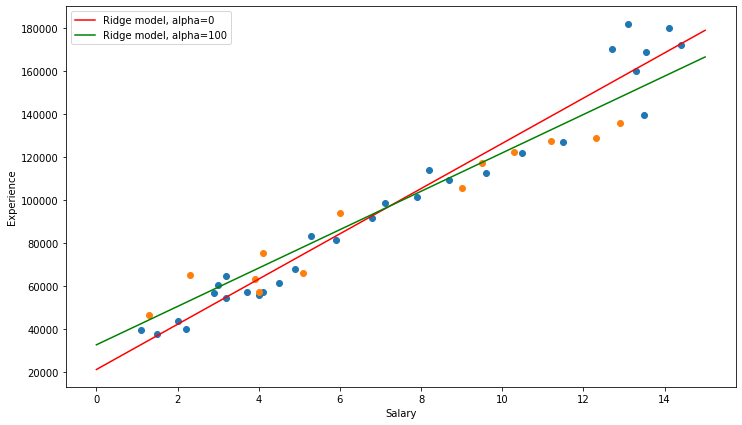

Training error = [128310429.22]
Testing error  = [72759235.92]


In [40]:
alpha = 100
b_0 = closed_form_ridge(X_train, y_train)
b = closed_form_ridge(X_train, y_train, alpha)

print(b)

plt.figure(figsize=(12, 7))
plt.xlabel('Salary')
plt.ylabel('Experience')
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

x_new = np.arange(0, np.maximum(X_train.max(), X_test.max()) + 1, 1)
plt.plot(x_new, b_0[1] * x_new + b_0[0], label=f"Ridge model, alpha=0", c='r')
plt.plot(x_new, b[1] * x_new + b[0], label=f"Ridge model, alpha={alpha}", c='g')
plt.legend()
plt.show()

train_pred = b[1] * X_train + b[0]
test_pred = b[1] * X_test + b[0]

print(f"Training error = [{cost(train_pred, y_train)}]")
print(f"Testing error  = [{cost(test_pred, y_test)}]")

### Comment 
As we can observe, increasing alpha results in a change in the position of our function. The slope factor is smaller, which results in better results for our test data. However, we must remember that this is not a free operation because the input of training data is growing.